# Federated Learning for Anomaly Detection

This example shows how to detect anomalies in sequence or time series data.

To detect anomalies or anomalous regions in a collection of sequences or time series data, you can use an autoencoder. An autoencoder is a type of model that is trained to replicate its input by transforming the input to a lower dimensional space (the encoding step) and reconstructing the input from the lower dimensional representation (the decoding step). Training an autoencoder does not require labeled data.

<b>An autoencoder itself does not detect anomalies</b>. Training an autoencoder using only representative data yields a model that can reconstruct its input data by using features learned from the representative data only.

<b>To check if an observation is anomalous using an autoencoder</b>:  input the observation into the network and measure the error between the original observation and the reconstructed observation.
- A large error between the original and reconstructed observations indicates that the original observation contains features unrepresentative of the data used to train the autoencoder and is anomalous.

In [115]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from typing import Dict, List, Tuple
from matplotlib import cm
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer

In [116]:
# Install Flower Package
!python -m pip install "flwr[simulation]"

In [117]:
DATA_FOLDER = 'data'

In [118]:
def plot_series(time, series, format="-", start=0, end=None, set_ylim=False, ylim_min=None, ylim_max=None):
    plt.plot(time[start:end], series[start:end], format)
    if set_ylim:
        plt.ylim(ylim_min, ylim_max)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Load the dataset

The dataset is a synthetic wave dataset generated using a random function. Reflecting the condition in the real-world, there are no examples of an anomaly in the training data. However, later when the deep learning model is deployed, there are chances that an anomaly can happen and we need to detect it.

The data:
- Contains 3 features ('measurement a', 'measurement b', 'measurement c')
- Only the test data that have labels for evaluation
- <b>Label 0 = Normal, Label 1 = Anomaly </b>

<img src="pict/pict_1.jpg" width="800" height="400">

In [119]:
# let's examine the df
example_df = pd.read_csv(f'{DATA_FOLDER}/client1_train.csv')

example_index = example_df['index'].to_numpy()
example_features = example_df[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()

In [120]:
example_features.shape

(1000, 3)

In [121]:
example_df.head()

,index,measurement_a,measurement_b,measurement_c
0,0.0,10.496714,29.938373,7.521951
1,1.0,9.861736,27.362095,0.928559
2,2.0,10.647689,28.562044,8.860810
3,3.0,11.523030,35.617002,6.720426
4,4.0,9.765847,22.888880,6.738350


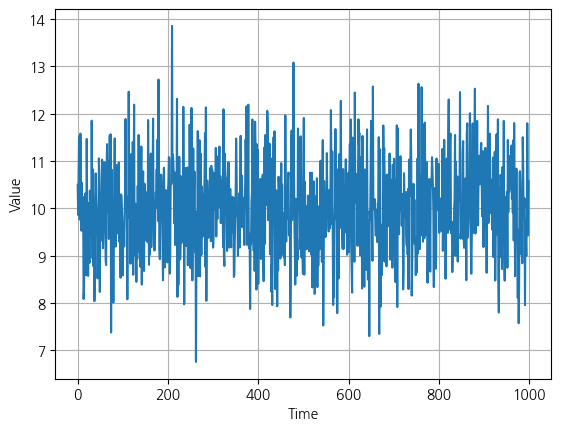

In [122]:
# Example of normal data
plot_series(example_index, example_features[:,0], format="-", start=0, end=None)

### Compare the data

Let's see the comparison:
- In the training data, we have no examples of anomalies
- In the test data, there are instances of anomalies

In [123]:
# load another data
example_df_2 = pd.read_csv(f'{DATA_FOLDER}/client1_test.csv')

example_index_2 = example_df_2['index'].to_numpy()
example_features_2 = example_df_2[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()

/tmp/ipykernel_9422/1383357068.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/iwan/anaconda3/envs/tf_flower_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


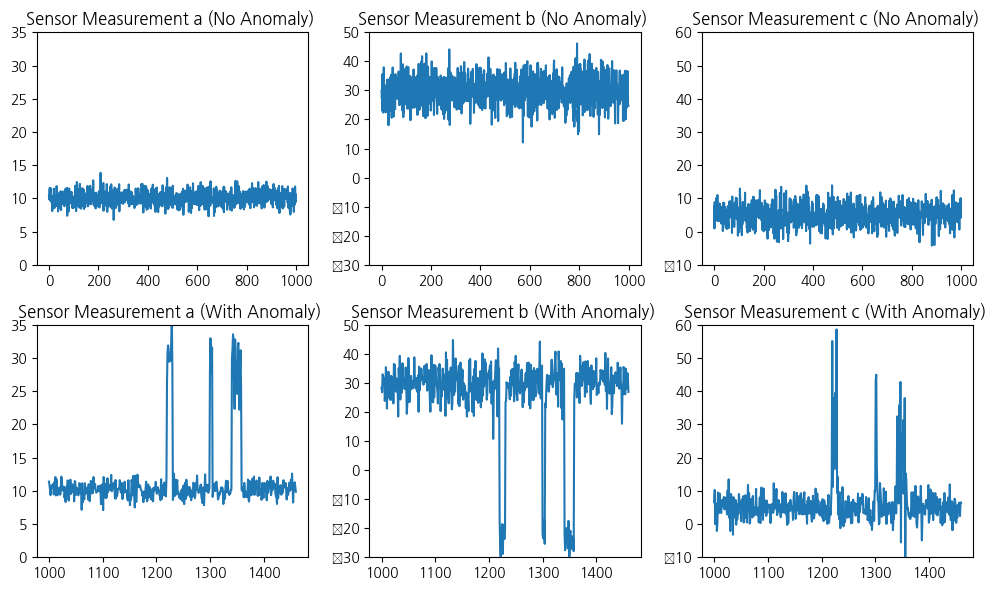

In [124]:
# create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

col_name = ['a', 'b', 'c']
ymin = [0, -30, -10]
ymax = [35, 50, 60]

for i, ax in enumerate(axes.flat):
    if i < 3:
        ax.plot(example_index, example_features[:,i%3], "-")
        ax.axis(ymin= ymin[i%3],ymax= ymax[i%3])
        ax.set_title(f"Sensor Measurement {col_name[i%3]} (No Anomaly) ")
    else:
        ax.plot(example_index_2, example_features_2[:,i%3], "-")
        ax.axis(ymin= ymin[i%3],ymax= ymax[i%3])
        ax.set_title(f"Sensor Measurement {col_name[i%3]} (With Anomaly) ")

plt.tight_layout()
plt.show()

## Building Autoencoder to detect anomalies : Centralized way

Let's recap the autoencoder capability to detect anomalies

<img src="pict/pict_2.jpg" width="1000" height="600">

In [125]:
# Autoencoder class model
@tf.keras.utils.register_keras_serializable()
class Autoencoder(tf.keras.Model):
    def __init__(self, output_shape=3, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(latent_dim ,activation='relu'),
            layers.Dense(latent_dim/2 ,activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim ,activation='relu'),
            layers.Dense(output_shape, activation='sigmoid'),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [126]:
# build autoencoder
model = Autoencoder()
# because we have 3 features ( measurement a-c)
model.build(input_shape=(None, 3))

model.compile(optimizer='adam', loss='mse')

In [127]:
# build centralized dataset

X_train = []
X_test = []
y_test = []
for client in ['client1', 'client2', 'client3']:
    df = pd.read_csv(f'{DATA_FOLDER}/{client}_train.csv')
    
    feat = df[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()
    X_train.append(feat)
    
    df_test = pd.read_csv(f'{DATA_FOLDER}/{client}_test.csv')
    y = df_test['labels'].to_numpy().astype(np.int64)
    feat_test = df_test[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()
    
    X_test.append(feat_test)
    y_test.append(y)

# concatonate df
X_train = np.concatenate(X_train, axis=0)
X_test  = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [128]:
# normalize the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [129]:
loss_to_infer = tf.keras.losses.MeanSquaredError(reduction='none',
                                                 name='mean_squared_error'
                                                )

In [130]:
model.fit(X_train, X_train, epochs=15, batch_size=128)
# PARAMETER: loss threshold, to consider sample as outlier
predictions = model.predict(X_train)
collection_of_losses = loss_to_infer(X_train, predictions).numpy()
# threshold losses is : mean + 2.8 * std
threshold_losses = collection_of_losses.mean() + 3 * collection_of_losses.std()
print(f"current error threshold: {threshold_losses}")

Epoch 1/15
24/24 [==============================] - 1s 2ms/step - loss: 0.0182
Epoch 2/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 3/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 5/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 6/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 7/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 9/15
24/24 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 10/15
24/24 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 11/15
24/24 [==============================] - 0s 4ms/step - loss: 7.8224e-04
Epoch 12/15
24/24 [==============================] - 0s 4ms/step - loss: 2.7728e-04
Epoch 13/15
24/24 [======================

In [131]:
predictions = model.predict(X_test)
collection_of_losses = loss_to_infer(X_test, predictions).numpy()

label_prediction = np.where(collection_of_losses > threshold_losses, 1, 0)

accuracy = accuracy_score(y_test, label_prediction)
print({"accuracy": accuracy})

44/44 [==============================] - 0s 859us/step
{'accuracy': 0.9927693420101229}


15/15 [==============================] - 0s 928us/step


/tmp/ipykernel_9422/464212350.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/iwan/anaconda3/envs/tf_flower_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


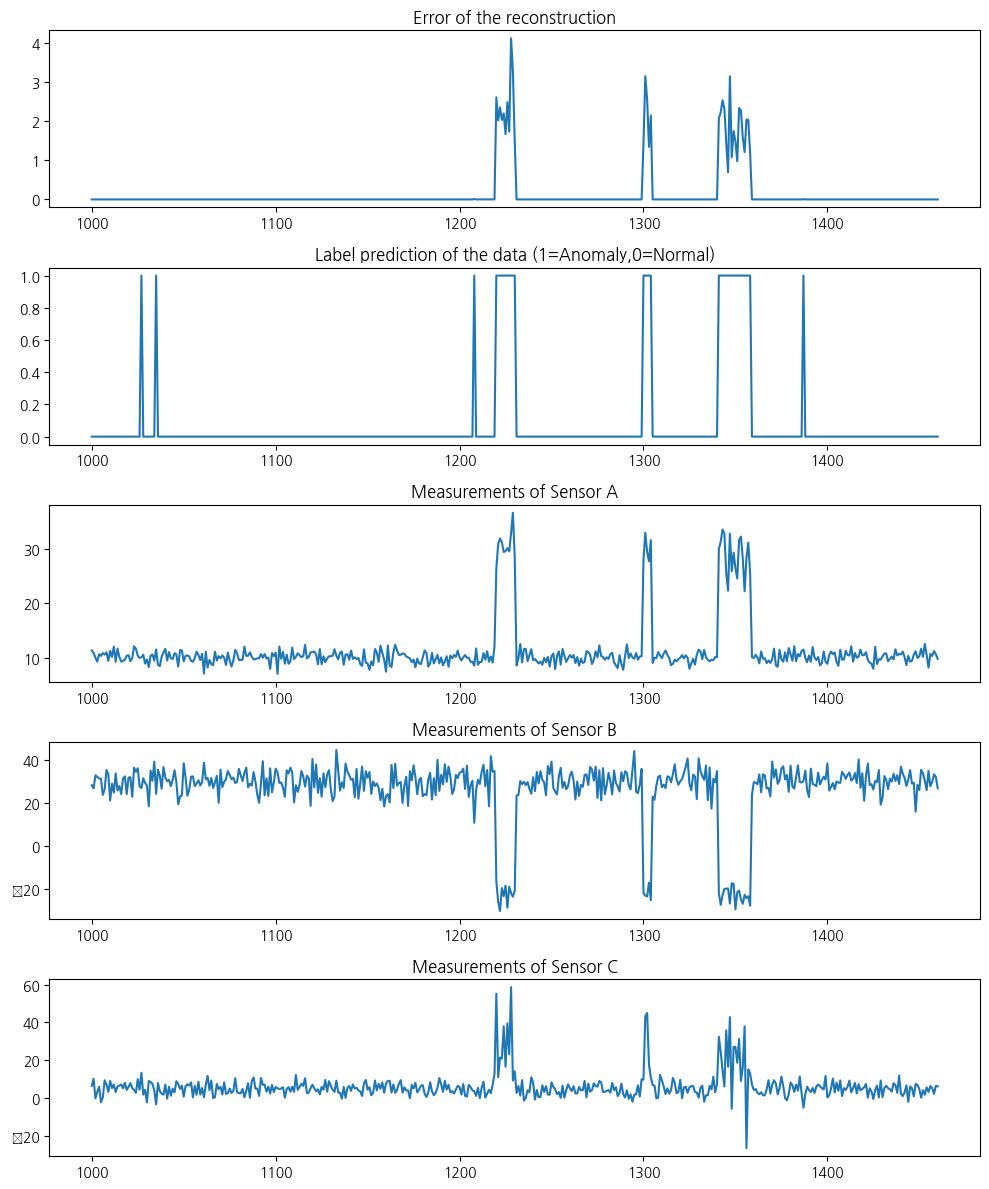

In [132]:
# try on some client data for visualization
X_test = example_features_2

y_test = example_df_2['labels'].to_numpy().astype(np.int64)

X_test = scaler.transform(X_test)

predictions = model.predict(X_test)
collection_of_losses = loss_to_infer(X_test, predictions).numpy()
loss = np.mean(collection_of_losses)
## predict the label (outlier=1) and normal=0
label_prediction = np.where(collection_of_losses > threshold_losses, 1, 0)

# let's plot the error and see the connection between the error and prediction

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(10, 12))

# plot error of the reconstruction
ax1.plot(example_index_2, collection_of_losses, "-")
ax1.set_title(f"Error of the reconstruction")

# the label prediction from the error threshold
ax2.plot(example_index_2, label_prediction, "-")
ax2.set_title(f"Label prediction of the data (1=Anomaly,0=Normal)")

ax3.plot(example_index_2, example_features_2[:,0], "-")
ax3.set_title(f"Measurements of Sensor A")

ax4.plot(example_index_2, example_features_2[:,1], "-")
ax4.set_title(f"Measurements of Sensor B")

ax5.plot(example_index_2, example_features_2[:,2], "-")
ax5.set_title(f"Measurements of Sensor C")

plt.tight_layout()
plt.show()

We can see that the autoencoder which is trained only on normal data is capable of detecting the anomalies.
- There are still minor prediction errors
- but we can <b>adjust</b> the scale of the <b>standard deviation of the error threshold</b> to mitigate this.

## Federated Learning Setting

In the federated learning, we will have the same training procedure for the local training.

We will use a package to simulate more device instances called [flower](https://flower.ai)!

Some notable differences are:
- There is a server who coordinates the training
- The model that will be used is a global model
- There are collaborations between other clients !!

<img src="https://miro.medium.com/v2/resize:fit:1400/0*O-8W-wIPKnOS1O2B.png" width="600" height="400">

In [133]:
import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

In [134]:
NUMBER_OF_CLIENTS = 3

### Create Client Instance

There are several important parts for Flower CLient Instances:
1. ___ init __ : Initializes the client. Sets up client-specific configurations such as the local model, dataset, or other parameters. Typically, you pass the local model and dataset as arguments and store them as instance variables.
2. get_parameters(): Returns the current model parameters (weights) to the federated server.
3. fit(): Trains the local model on the client's dataset and returns the updated parameters and training metrics.Runs local training using the provided training dataset.
4. evaluate() : Evaluates the local model's performance on the test dataset and returns the evaluation metrics.

In [135]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, X_test, y_test) -> None:
        # Create autoencoder
        self.model =Sequential([
            InputLayer(input_shape=(3,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(3, activation='sigmoid'),
            ])
        self.model.compile(optimizer='adam', loss='mse')
        self.model.build()

        self.loss_to_infer = tf.keras.losses.MeanSquaredError(reduction='none',name='mean_squared_error')

        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test

        # normalize the data
        scaler = MinMaxScaler()
        scaler.fit(self.X_train)
        self.X_train = scaler.transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        # initial threshold loss
        self.threshold_losses= 0.0
        self.STD_loss_multiplication = 2.0

    def get_parameters(self, config):
        # initial model parameter asked by server
        return self.model.get_weights()

    def fit(self, parameters, config):  # type: ignore
        # perform local training
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.X_train, epochs=3, batch_size=128, verbose=0)

        return (
            self.model.get_weights(),
            len(self.X_train),
            {},
        )

    def evaluate(self, parameters, config):  # type: ignore
        self.model.set_weights(parameters)

        predictions = self.model.predict(self.X_train)
        collection_of_losses =  self.loss_to_infer(self.X_train, predictions).numpy()
        # threshold losses is : mean + STD_loss_multiplication * std
        self.threshold_losses = collection_of_losses.mean() + self.STD_loss_multiplication * collection_of_losses.std()

        predictions = self.model.predict(self.X_test)
        collection_of_losses = self.loss_to_infer(self.X_test, predictions).numpy()
        loss = np.mean(collection_of_losses)

        ## predict the label (outlier=1) and normal=0
        label_prediction = np.where(collection_of_losses > self.threshold_losses, 1, 0)
        accuracy = accuracy_score(self.y_test, label_prediction)

        return float(loss), len(self.X_test), {"accuracy": accuracy}

In [136]:
def get_client_fn():
    """return a function to construct a client.

    the VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """construct a FlowerClient with its own dataset partition."""
        train_df = pd.read_csv(f'{DATA_FOLDER}/client{int(cid)+1}_train.csv')
        X_train = train_df[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()

        test_df = pd.read_csv(f'{DATA_FOLDER}/client{int(cid)+1}_test.csv')
        X_test = test_df[['measurement_a', 'measurement_b', 'measurement_c']].to_numpy()
        y_test = test_df['labels'].to_numpy().astype(np.int64)

        # Create and return client
        return FlowerClient(X_train, X_test, y_test).to_client()

    return client_fn

### Create Server Instance

In the server instance , we define how we process the metrics of each client and additional parameter for the federated learning algorithm.

In [137]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [138]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    min_available_clients=NUMBER_OF_CLIENTS, # min available client to start
    evaluate_metrics_aggregation_fn=weighted_average, # how to aggregate the client evaluation metrics
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

### Start FL training

In [ ]:
# Enable GPU growth in your main process for simulation
#enable_tf_gpu_growth()

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(),
    num_clients=NUMBER_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    #actor_kwargs={
    #    "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    #},
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-11-27 11:32:58,914	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 10351135950.0, 'GPU': 2.0, 'node:220.67.127.75': 1.0, 'accelerator_type:RTX': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'object_store_memory': 5175567974.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=19194) 2024-11-27 11:33:00.410566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19194) 2024-11-